Завантажимо дані

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1'

dictionary = pd.read_csv('c:\\Users\\User\\miniconda3\\envs\\labs\\data-dictionary.csv')
data = pd.read_csv('c:\\Users\\User\\miniconda3\\envs\\labs\\Country-data.csv')
print(dictionary)
print(data)

  Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...
                 country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4 

Перевіримо на наявність невизначених значень. Таких немає.

In [2]:
print(data.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


Визначимо викиди у факторах, які будемо досліждувати. Відсіємо ті країни, які мають значення більші від середнього значення на три стандартні відхилення.

In [3]:
data_cleaned=data.copy()
for column in data.columns:
    if column in ['income', 'gdpp']:
        mean = data[column].mean()
        std = data[column].std()
        limit = mean + 3 * std
        outliers = data[(data[column] > limit)]
        data_cleaned = data[~(data[column] > limit)].reset_index(drop=True)
        print(f"Кількість викидів у стовпці '{column}': {outliers.shape[0]}")
        print(outliers[['country', column]])  



Кількість викидів у стовпці 'income': 4
        country  income
23       Brunei   80600
82       Kuwait   75200
91   Luxembourg   91700
123       Qatar  125000
Кількість викидів у стовпці 'gdpp': 4
         country    gdpp
91    Luxembourg  105000
114       Norway   87800
123        Qatar   70300
145  Switzerland   74600


Виведемо нові дані

In [4]:
print(data_cleaned)

                 country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
158              Vanuatu        29.2     46.6    5.25     52.7    2950   
159            Venezuela        17.1     28.5    4.91     17.6   16500   
160              Vietnam        23.3     72.0    6.84     80.2    4490   
161                Yemen        56.3     30.0    5.18     34.4    4480   
162               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49   

Проведемо однофакторний аналіз. Зобразимо графік розсіювання кожного з трьох факторів в залежності від країн.

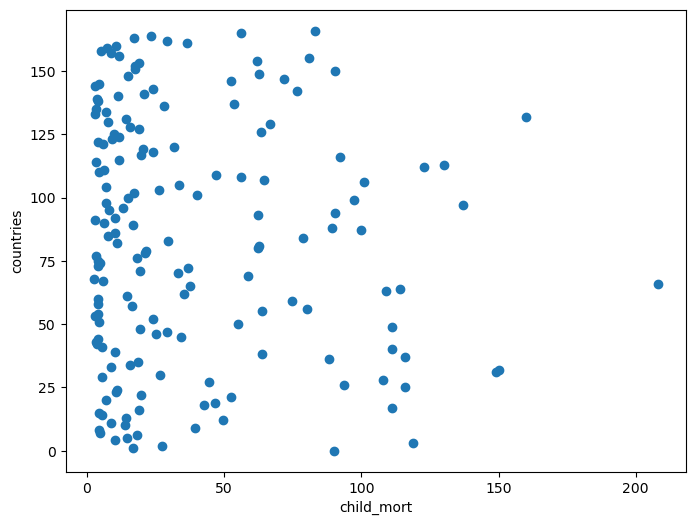

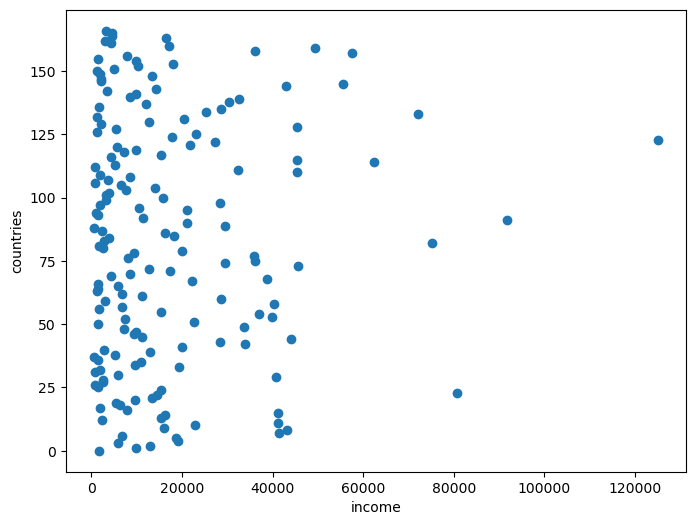

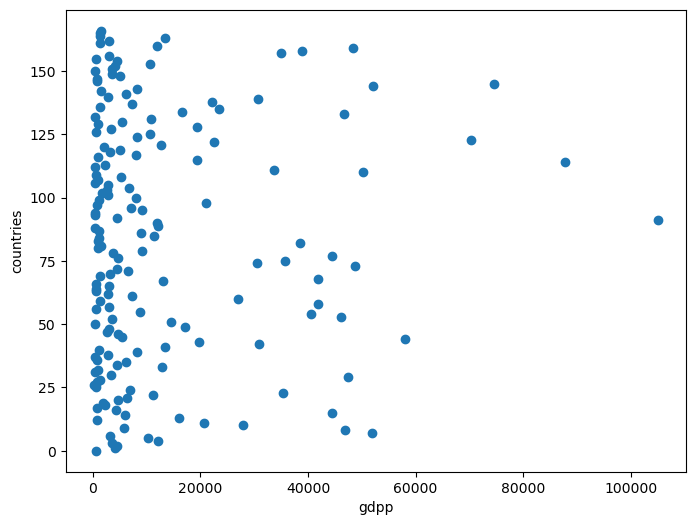

In [5]:
columns = ['child_mort', 'income', 'gdpp']
for column in columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[column], data.index)
    plt.xlabel(column) 
    plt.ylabel('countries')
    plt.show()

Двофакторний аналіз. Зобразимо графік розсіювання попарної залежності наших факторів.

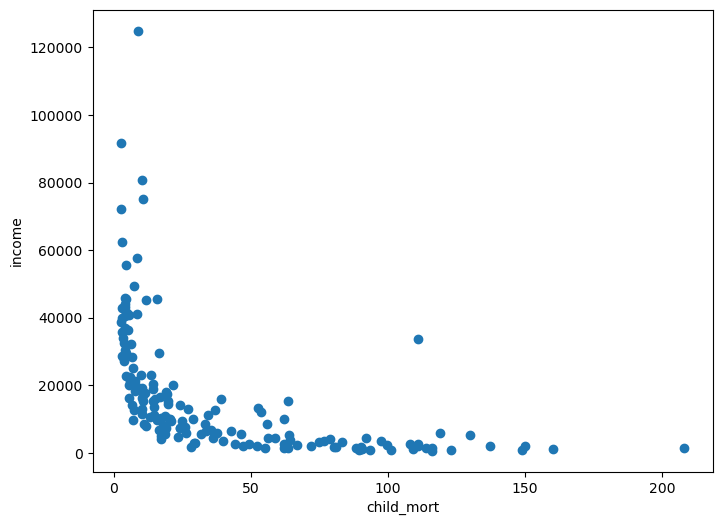

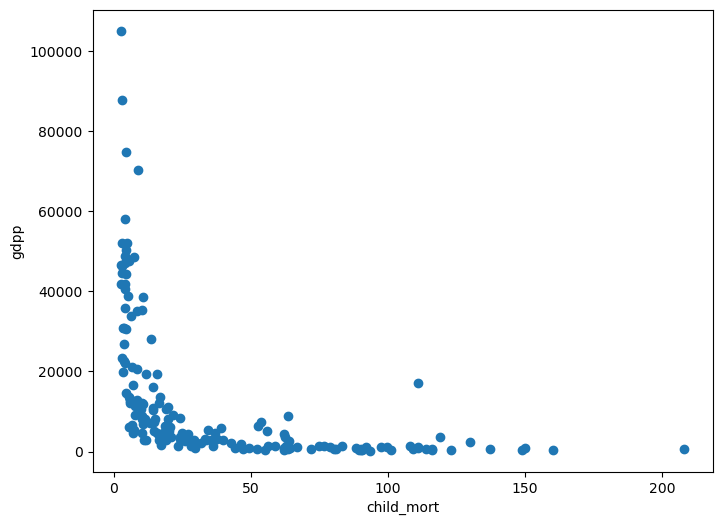

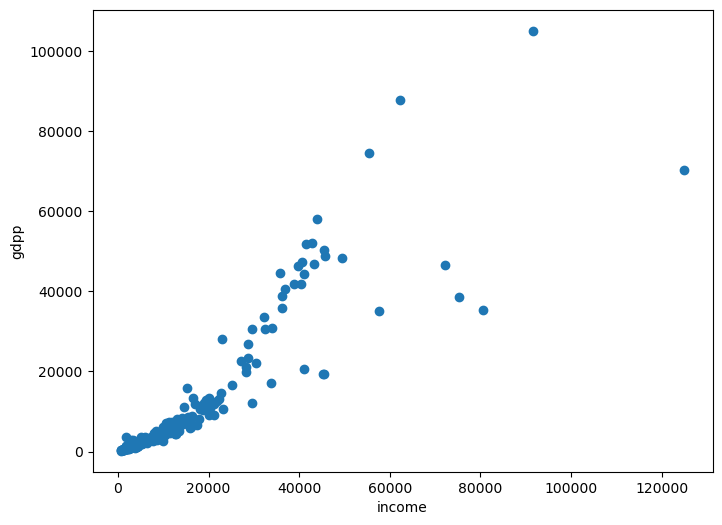

In [6]:
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        plt.figure(figsize=(8, 6))
        plt.scatter(data[columns[i]], data[columns[j]])
        plt.xlabel(columns[i])
        plt.ylabel(columns[j])
        plt.show()

Визначимо оптимальну кількість кластерів ліктьовим методом. Результат: оптимальна кількість кластерів - 3.

C:\Users\User\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

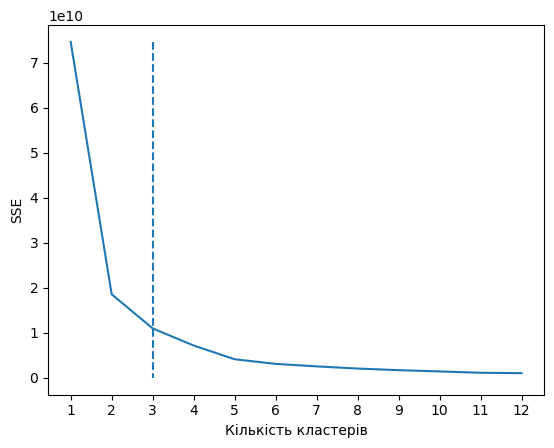

In [7]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_cleaned.select_dtypes(include=['int64', 'float64']))
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 13), sse, curve="convex", direction="decreasing")
k = kl.elbow

plt.plot(range(1, 13), sse)
plt.xticks(range(1, 13))
plt.xlabel("Кількість кластерів")
plt.ylabel("SSE")
plt.vlines(k, sse[0], sse.index(max(sse)), linestyles='dashed')
plt.show()


Посортуємо країни в кластери.

In [8]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_cleaned.select_dtypes(include=['int64', 'float64']))
clusters = kmeans.labels_.astype('int64')
data_cleaned['cluster'] = clusters
print(data_cleaned)

                 country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
158              Vanuatu        29.2     46.6    5.25     52.7    2950   
159            Venezuela        17.1     28.5    4.91     17.6   16500   
160              Vietnam        23.3     72.0    6.84     80.2    4490   
161                Yemen        56.3     30.0    5.18     34.4    4480   
162               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  cluster  
0         9.44        56.2       5.82    553        2  

C:\Users\User\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Визначимо середнє значення кожного з факторів для кожного кластера. Спостерігаємо, що кластер 1 та 2 мають протилежні значення (кластер 1: низька дитяча смертність, високе ВВП та дохід; кластер 2 - висока дитяча смертність, низький дохід на ВВП), кластер 0 має середні значення між двома попередніми.

In [9]:
clust_data = data_cleaned.select_dtypes(include=['int64', 'float64']).groupby('cluster').mean()
print(clust_data[['child_mort', 'income', 'gdpp']])

         child_mort        income          gdpp
cluster                                        
0         15.345000  20487.500000  12884.500000
1          5.762963  44577.777778  39937.037037
2         58.356250   5266.281250   2433.687500


Візуалізуємо різниця між кластерами для кожного фактора

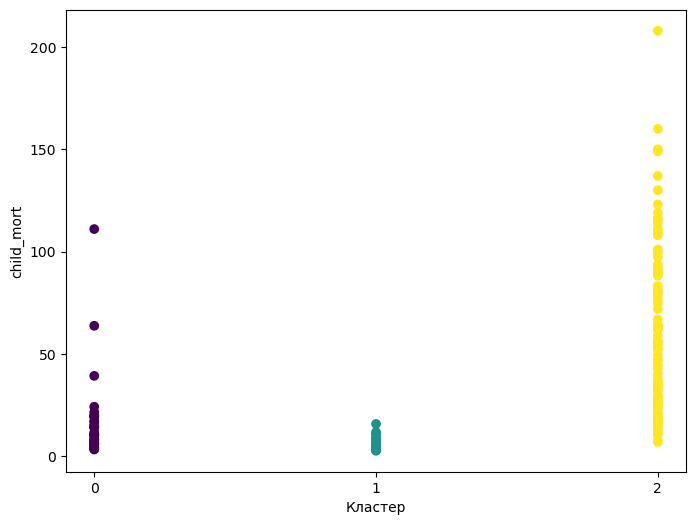

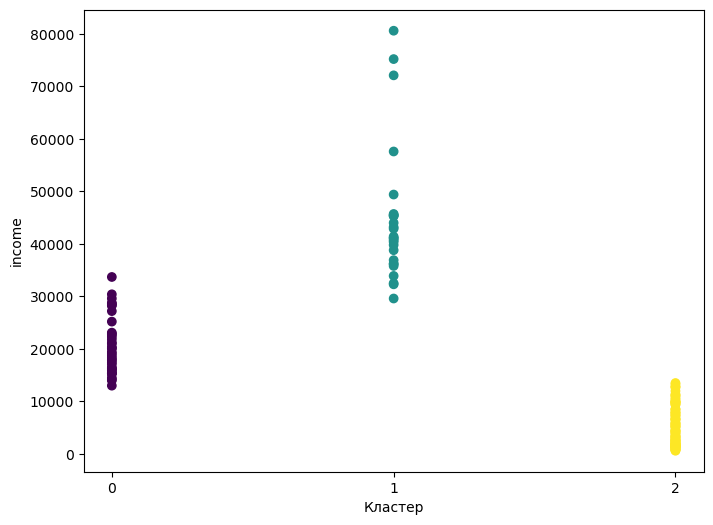

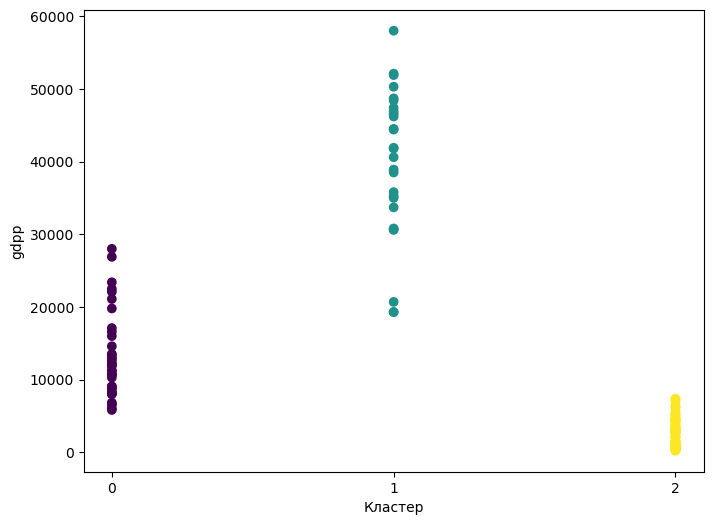

In [10]:
for column in columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(data_cleaned['cluster'], data_cleaned[column], c=data_cleaned['cluster'], cmap='viridis')
    plt.xlabel('Кластер')
    plt.ylabel(column)
    plt.xticks([0, 1, 2])
    plt.show()

Також візуалізуємо попарну залежність факторів для кластерів.

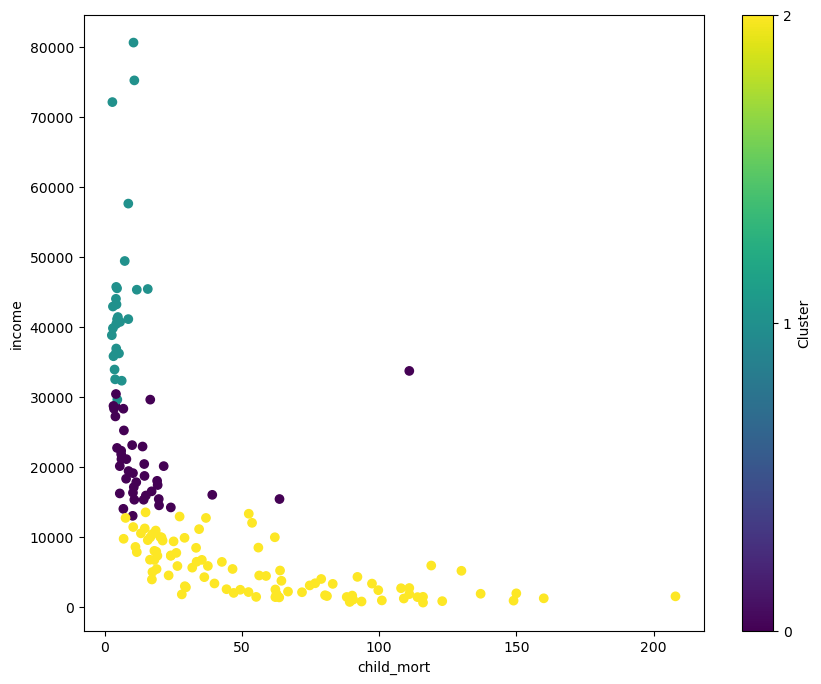

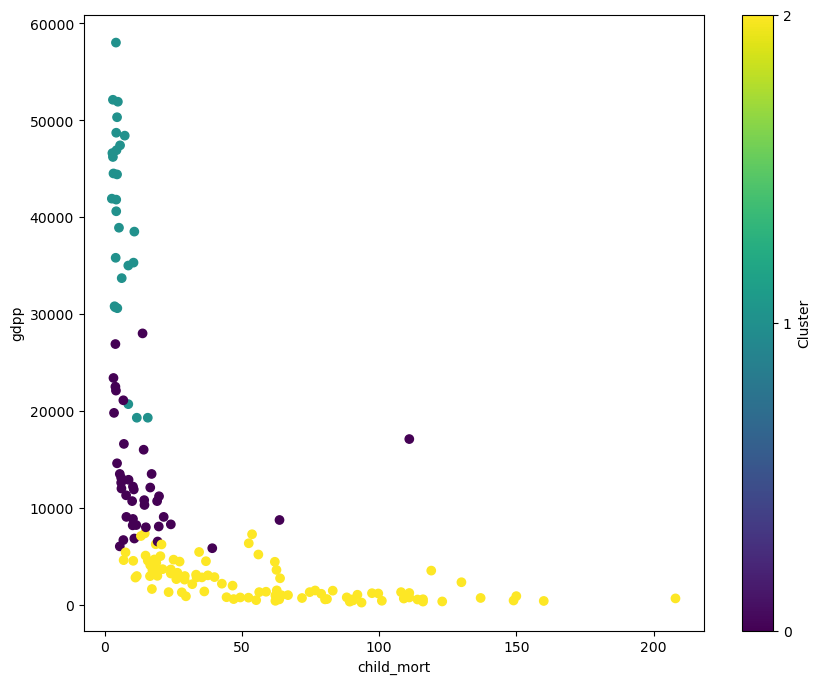

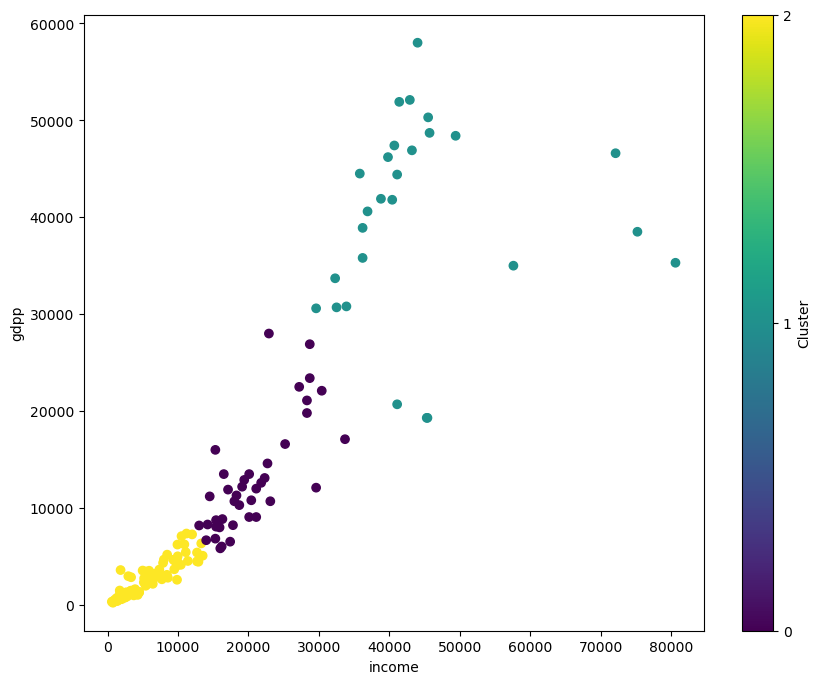

In [11]:
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        plt.figure(figsize=(10, 8))
        plt.scatter(data_cleaned[columns[i]], data_cleaned[columns[j]], c=data_cleaned['cluster'], cmap='viridis')
        plt.xlabel(columns[i])
        plt.ylabel(columns[j])
        plt.colorbar(label='Cluster',ticks=[0,1,2] )
        plt.show()



У результаті обчислення середнього та візуалізації зрозуміло, що країни з кластеру 2 потребують найбільше допомоги. Визначимо ці країни.

In [12]:
cluster_2 = data_cleaned[data_cleaned['cluster'] == 2]
print(cluster_2['country'])

0      Afghanistan
1          Albania
2          Algeria
3           Angola
6          Armenia
          ...     
157     Uzbekistan
158        Vanuatu
160        Vietnam
161          Yemen
162         Zambia
Name: country, Length: 96, dtype: object


З цих країн визначимо половину, в яких дитяча смертність є найбільшою

In [15]:
highest_child_mort = cluster_2.nlargest(40, 'child_mort')
print(highest_child_mort[['country', 'child_mort']])


                      country  child_mort
66                      Haiti       208.0
129              Sierra Leone       160.0
32                       Chad       150.0
31   Central African Republic       149.0
96                       Mali       137.0
112                   Nigeria       130.0
111                     Niger       123.0
3                      Angola       119.0
25               Burkina Faso       116.0
37           Congo, Dem. Rep.       116.0
64              Guinea-Bissau       114.0
17                      Benin       111.0
40              Cote d'Ivoire       111.0
63                     Guinea       109.0
28                   Cameroon       108.0
105                Mozambique       101.0
87                    Lesotho        99.7
98                 Mauritania        97.4
26                    Burundi        93.6
114                  Pakistan        92.1
93                     Malawi        90.5
146                      Togo        90.3
0                 Afghanistan     

А тепер визначимо 10 країн, в яких також низький рівень ввп та доходу. Це будуть наші 10 країн у порядку першочерговості надання допомоги.

In [16]:
top_5_lowest_gdpp_income = highest_child_mort.nsmallest(10, ['gdpp', 'income'])
print(top_5_lowest_gdpp_income[['country', 'child_mort', 'income', 'gdpp']])

                      country  child_mort  income  gdpp
26                    Burundi        93.6     764   231
88                    Liberia        89.3     700   327
37           Congo, Dem. Rep.       116.0     609   334
111                     Niger       123.0     814   348
129              Sierra Leone       160.0    1220   399
92                 Madagascar        62.2    1390   413
105                Mozambique       101.0     918   419
31   Central African Republic       149.0     888   446
93                     Malawi        90.5    1030   459
146                      Togo        90.3    1210   488
